# 平铺图像文件格式：zarr

在处理大型图像数据时，通常会使用特殊的文件格式，如[zarr](https://zarr.readthedocs.io/en/stable/)格式。Zarr将图像数据存储为块。无需将庞大的图像数据集从磁盘加载后再进行平铺，而是可以加载单个zarr块，处理它们，然后将结果保存回磁盘。这样就可以在不将整个大图像加载到内存的情况下处理大图像。

使用这些格式会带来额外的挑战，例如，将大图像重新保存为基于zarr的小块必须在能够打开大图像的计算机上进行。本笔记本展示了如何在一个略显不现实的场景中实现这一点：我们首先加载数据集以将其重新保存为块，最后，我们从磁盘加载这些块并将其可视化。在实际场景中，这两个步骤可能无法同时进行。根据具体情况，这两个步骤必须进行即兴处理。

另请参阅
* [Genevieve Buckley的gist：save_as_zarr.ipynb](https://gist.github.com/GenevieveBuckley/d94351adcc61cb5237a6c0a540c14cf6)
* [dask.array.from_zarr](https://docs.dask.org/en/stable/generated/dask.array.from_zarr.html#dask.array.from_zarr)


In [1]:
import zarr
import dask.array as da
import numpy as np
from skimage.io import imread, imshow
from numcodecs import Blosc

出于演示目的，我们使用由德累斯顿工业大学卡尔·古斯塔夫·卡鲁斯大学医院OncoRay的Theresa Suckert提供的数据集。该数据集采用[许可证：CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)授权。我们在这里使用了一个裁剪版本，该版本被重新保存为8位图像，以便能够与笔记本一起提供。您可以在[在线](https://zenodo.org/record/4276076#.YX1F-55BxaQ)找到完整大小的16位CZI格式图像。

In [2]:
image = imread('../../data/P1_H_C3H_M004_17-cropped.tif')[1]

# for testing purposes, we crop the image even more.
# comment out the following line to run on the whole 5000x2000 pixels
image = image[1000:1500, 1000:1500]

image.shape

(500, 500)

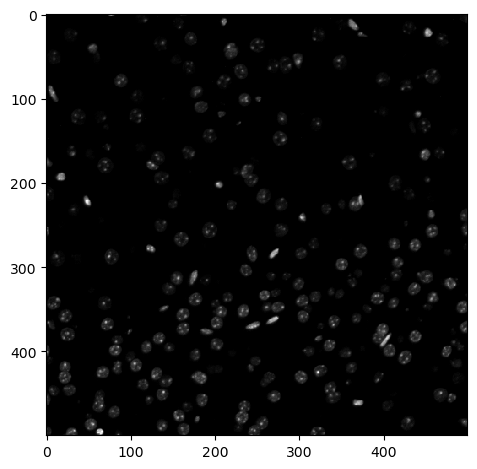

In [3]:
imshow(image)

## 保存为zarr格式
我们现在将把我们的大图像重新保存为[zarr](https://zarr.readthedocs.io/en/stable/)文件格式。

In [4]:
#compress AND change the numpy array into a zarr array
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)

chunk_size = (100, 100)

zarray = zarr.array(image, chunks=chunk_size, compressor=compressor)

In [5]:
zarr_filename = '../../data/P1_H_C3H_M004_17-cropped.zarr'
zarr.convenience.save(zarr_filename, zarray)

然后你会看到创建了一个具有给定名称的文件夹。在该文件夹中会有许多文件。每个文件对应一个图像块。

## 加载zarr
仅出于演示目的，我们将加载zarr支持的平铺图像并进行可视化。在处理大数据时，这一步可能无法实现。

In [6]:
zarr_result = da.from_zarr(zarr_filename)
zarr_result

dask.array<from-zarr, shape=(500, 500), dtype=uint8, chunksize=(100, 100), chunktype=numpy.ndarray>

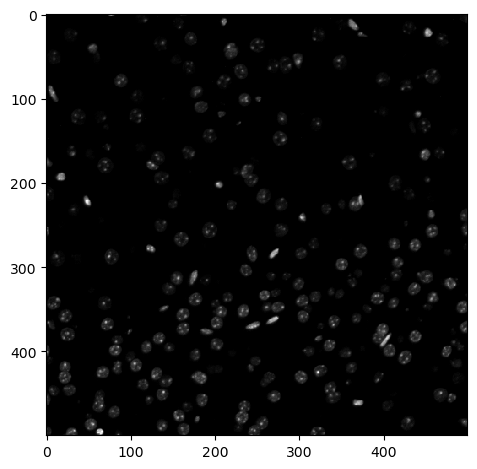

In [7]:
result = zarr_result.compute()

imshow(result)